# Question 1: Python Basics and Data Manipulation

Objective: \
Demonstrate basic Python skills and data manipulation using Pandas.

Task: \
Load a given CSV file containing metal prices into a Pandas DataFrame.
Filter the data to include only 'Copper' and 'Zinc' for the year 2021.
Calculate the average price per month for each metal and plot it.

## Solution:
For this question I tried to write a code that can easly adapt to select and visualise different years and metals. I decided to plot the average price per month with $\pm$ 1 std as it adds more information to the average value. 

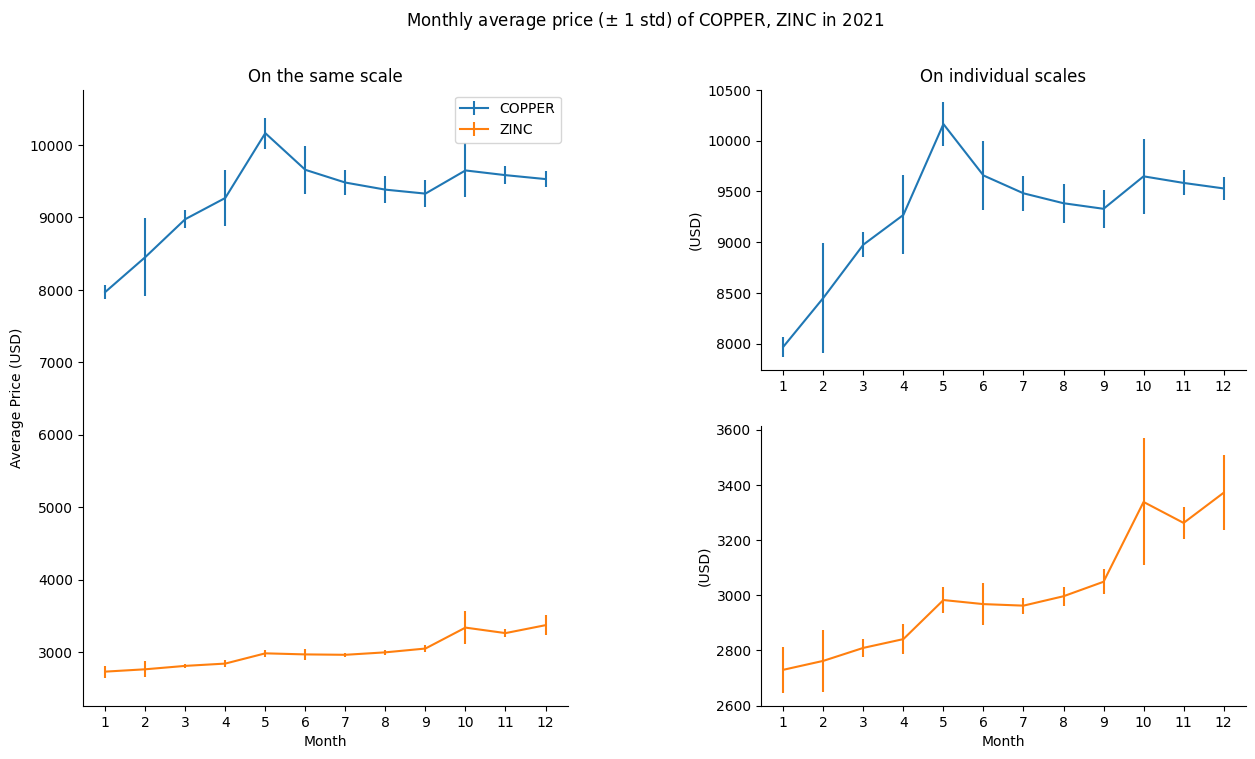

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_data(data_path: str, metals: list[str], years: list[str]) -> pd.DataFrame:
    """Load the data from the CSV file and select the required metals and years.
    INPUTs:
    - data_path: str, path to the CSV file
    - metals: list of str, metals to select (e.g. ["COPPER"])
    - years: list of int, years to select
    OUTPUTs:
    - df: pandas DataFrame, selected data with columns ["Dates", metals]
    """

    # Load the data
    raw_df = pd.read_csv(data_path)
    # Get columns names with selected metals
    columns_metals = raw_df.iloc[2, 1:-1].values
    columns_metals = [col.split(" ")[1] for col in columns_metals]
    # Get the mask of the columns to select, the first column is the Date
    mask_columns = np.concatenate(([True], np.isin(columns_metals, metals), [False]))
    # Select only columns in the mask, also the first 6 rows are headers
    df = raw_df.iloc[6:, mask_columns].copy()
    df.columns = np.concatenate((["Dates"], metals))
    # Ensure the data types are correct. the format dd/mm/yyyy should work better for pandas
    df["Dates"] = pd.to_datetime(df["Dates"], format="%d/%m/%Y", errors="coerce")
    for metal in metals:
        df[metal] = pd.to_numeric(df[metal], errors="coerce")
    # Select only the required years
    df = df[df["Dates"].dt.year.isin(years)]
    # Check the data doesn't have any missing values, otherwise it needs to be addressed
    if not (df.isna().sum() == 0).all():
        raise ValueError(
            f"There are NaN values in the data. Please check the data and try again.\n{df.isna().sum()}"
        )
    return df


def plot_average_price_per_month(df: pd.DataFrame, metals: list[str], years: list[str]) -> None:
    """Plot the average price per month for the selected metals and years.
    INPUTs:
    - df: pandas DataFrame, selected data with columns ["Dates", metals]
    - metals: list of str, metals to select (e.g. ["COPPER"])
    - years: list of int, years to select
    """

    # Group by Month-Year by adding a new column to the df
    df["Month-Year"] = df["Dates"].dt.to_period("M")
    monthly_avg = df.groupby(["Month-Year"], as_index=False)[metals].mean()
    monthly_avg.index.names = ["Month"]
    monthly_stds = df.groupby(["Month-Year"], as_index=False)[metals].std()
    monthly_stds.index.names = ["Month"]

    # Plot the data
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(
        f"Monthly average price ({r'$\pm$'} 1 std) of {', '.join(metals)} in {', '.join(map(str, years))}",
    )
    grid = plt.GridSpec(nrows=len(metals), ncols=2, figure=fig, wspace=0.4, hspace=0.2)

    # Plot the averages together
    ax = fig.add_subplot(grid[0 : len(metals), 0])
    ax.set_title("On the same scale")
    colors = []
    for i, metal in enumerate(metals):
        ax.errorbar(
            monthly_avg.index + 1,
            monthly_avg[metal],
            yerr=monthly_stds[metal],
            label=f"{metal}",
        )
        # Store the colors for matching the individual plots
        colors.append(ax.lines[i].get_color())
    ax.set_xlabel("Month")
    ax.set_xticks(monthly_avg.index + 1)
    ax.set_ylabel("Average Price (USD)")
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend()

    # Plot the prices separately as the scales are different
    for i, metal in enumerate(metals):
        ax = fig.add_subplot(grid[i, 1])
        if i == 0:
            ax.set_title("On individual scales")
        ax.errorbar(
            monthly_avg.index + 1,
            monthly_avg[metal],
            yerr=monthly_stds[metal],
            color=colors[i],
        )
        ax.set_ylabel("(USD)")
        if i == len(metals) - 1:
            ax.set_xlabel("Month")
        ax.spines[["top", "right"]].set_visible(False)
        ax.set_xticks(monthly_avg.index + 1)

    plt.show()


### Parameters ###

data_path = f"{os.pardir}/data/MarketData.csv"
# Metals to select
metals = ["COPPER", "ZINC"]
# Years to select
years = [2021]

# Load the data
df = get_data(data_path, metals, years)

# Plot the data
plot_average_price_per_month(df, metals, years)
